In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from matplotlib import patches
from scipy import ndimage

import sys

sys.path.insert(1, '/rds/general/user/le322/home/synthPy/src/')

import solver.rtm_solver as rtm
import field_generator.gaussian1D as g1
import field_generator.gaussian2D as g2
import field_generator.gaussian3D as g3
import utils.power_spectrum as util
import utils.power_spectrum as spectrum
import solver.minimal_solver as s

from utils.imaging import Image

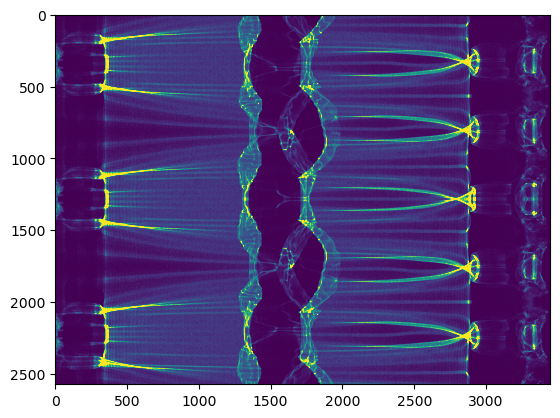

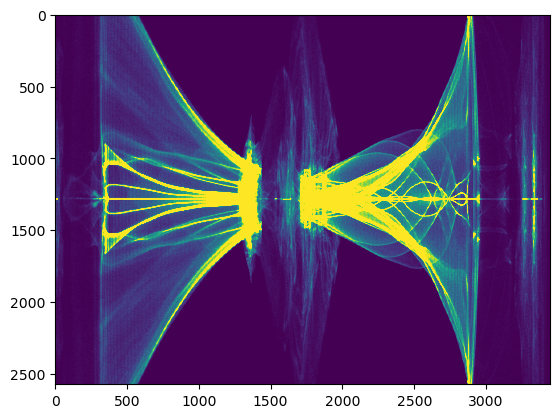

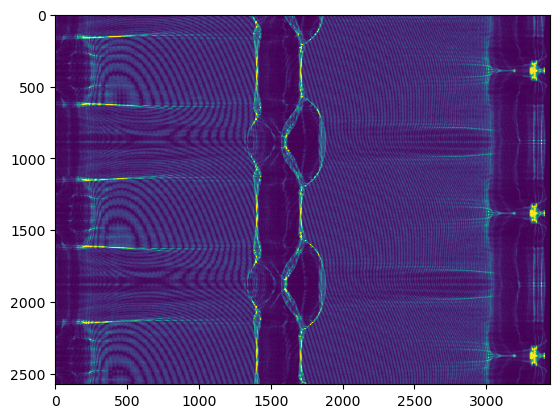

In [2]:
sideOn_sh03 = pickle.load(open('/rds/general/user/le322/home/synthPy/output/fluid sim/double_mesh/colliding_mesh003_SideOn1064_shadow.pkl', "rb")).H
sideOn_re03 = pickle.load(open('/rds/general/user/le322/home/synthPy/output/fluid sim/double_mesh/colliding_mesh003_SideOn1064_refract.pkl', "rb")).H
endOn_int03 = pickle.load(open('/rds/general/user/le322/home/synthPy/output/fluid sim/double_mesh/colliding_mesh003_endOnInt.pkl', "rb")).H

plots = [sideOn_sh03,sideOn_re03,endOn_int03]
for graph in plots:
    plt.imshow(graph, clim = (0,10))
    plt.show()

In [3]:
_, wn, ps = spectrum.radial_2Dspectrum(sideOn_sh03[500:2500, 500:2500], 100,150, smooth = False)

/rds/general/user/le322/home/anaconda3/envs/MAGPIE_venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/le322/home/anaconda3/envs/MAGPIE_venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


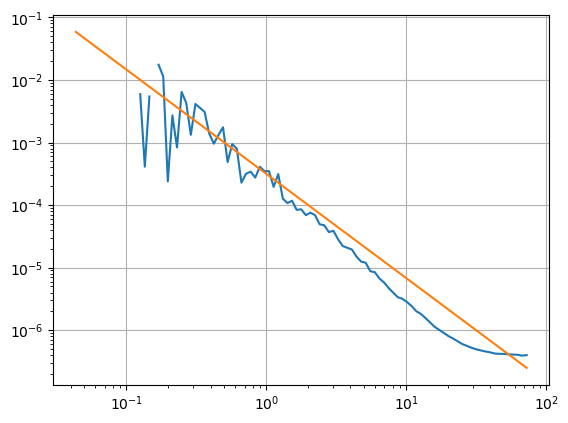

In [4]:
plt.plot(wn, ps)
plt.plot(wn, 10**-3.5*wn**(-5/3))
plt.xscale('log')
plt.yscale('log')
plt.grid()

LINESOUT

In [5]:
re = sideOn_re03


from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2, 1],[0,-1,-2], shape=(L, L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def clean(sig):
    baseline          =   baseline_als_optimized(sig, 4e10, 1e-3)
    sig_corr        =   (sig - baseline ) / baseline
    sig_norm       =   (sig_corr - sig_corr.min()) / (sig_corr.max() + sig_corr.min())

    return sig_norm
plt.figure(figsize = (16,3))

slice1 = re[:,1650]/ np.max(re[:, 1650])
x = np.linspace(-37, 37, len(slice1))
# plt.plot(re[:,1000]/ np.max(re[:, 1000]))


# plt.plot(clean(re[:, 1700]))

<Figure size 1600x300 with 0 Axes>

9.483325018640322


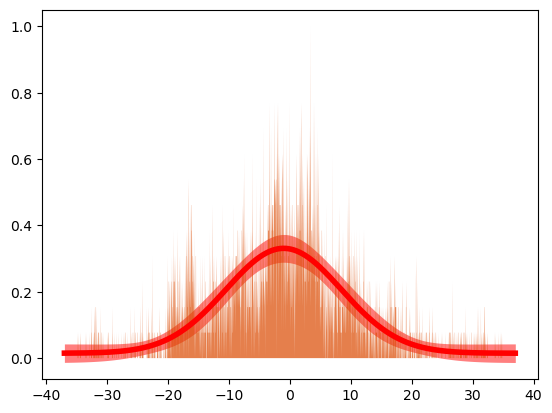

In [6]:
from lmfit.models import GaussianModel, ConstantModel



c1 = '#1C6758'   # dark green
c2 = '#006e23'   # ciano
c3 = '#6e0052'   # violet
c4 = '#db4900'   # purple


# ax1.plot(x, total1, lw=1.5, alpha = 15 / 15, zorder=2)
# ax2.plot(x, total2, lw=1.5, alpha = 15 / 15, zorder=2)

mod               =   GaussianModel() + ConstantModel()
mod.make_params()
mod.set_param_hint('sigma', value=2)
mod.set_param_hint('amplitude', value=1)
res1 = mod.fit(slice1, x = x, nan_policy='omit')

plt.plot(x, res1.best_fit, color='r', linewidth=4.0, zorder = 4)


nstd     = 8 # to draw 5-sigma intervals
error_up = res1.best_fit + nstd * res1.eval_uncertainty()
error_dw = res1.best_fit - nstd * res1.eval_uncertainty()

plt.fill_between(x, 
                error_up,
                error_dw, 
                color='r', alpha=0.5,  edgecolor="b", lw = 0)

plt.fill_between(x, slice1, facecolor = c4, alpha=0.7, zorder = 2)



sigma1 = res1.best_values['sigma']

print(sigma1)


In [7]:
def find_lz(sigma, epsilon = 1):
    ne = 1e24

    L_z = 10e-3
    lwl = 1053e-9
    c = 3e8
    omega = 2*np.pi*(c/lwl)
    nc = 3.14207787e-4*omega**2

    return ((ne**2)/(4*(nc**2)*((sigma*1e-3)**2)))*(epsilon**2)*(L_z)

[]

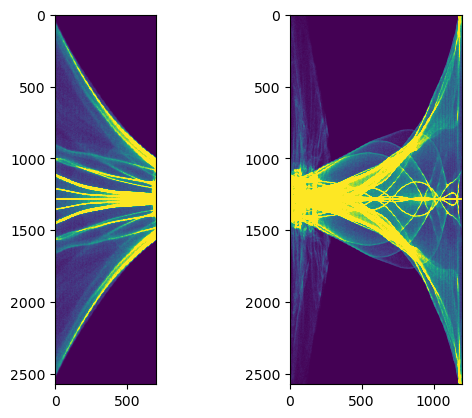

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(re[:, 600:1300], clim = (0,10))

ax[1].imshow(re[:, 1700:2900], clim = (0,10))
plt.plot()

analyse lineout vs max density gradient, take max phi and also sigma phi

In [9]:
scale_sh_x   =  re.shape[1]
scale_sh_y   =  re.shape[0]

pixel_size_y = (13.5/re.shape[1])
pixel_size_x = (13.5/re.shape[0]) # pixel size, mm/px in this case because bin = 10, pixel size = 52 um instead 5.4 um

scale_phi   =   1/(2 * pixel_size_y/400 * 1000)
# scale_phi   =  b.H.shape[0] / 13.5
refr_sh    =     Image(re, 0., scale_sh_x, scale_phi)
shadow_sh  =     Image(sideOn_sh03, 0, scale_sh_x, scale_sh_y)
 # pixel size, mm/px in this case because bin = 10, pixel size = 52 um instead 5.4 um

  #sensitivity is Lϕ/2, ϕ in radians, convert to mradians.

refr_sh    =     Image(re, 0., scale_sh_x, scale_phi)

o_sh       =        ndimage.center_of_mass(re)


refr_sh.set_origin(o_sh)


print('px shadow camera = ', shadow_sh.im.shape)
print('px refr camera = ', refr_sh.im.shape)

print('x0s = ', shadow_sh.px_to_mm((0,0))[0])
print('x1s = ', shadow_sh.px_to_mm((3448,0))[0])

print('x0r = ', refr_sh.px_to_mm((0,0))[0])
print('x1r = ', refr_sh.px_to_mm((3448,0))[0])

px shadow camera =  (2574, 3448)
px refr camera =  (2574, 3448)
x0s =  0.0
x1s =  1.0
x0r =  -0.3730521103920612
x1r =  0.6269478896079388


In [10]:
# sigma phi:

### scan spatially the image
Image.plot_mm

start  =  refr_sh.px_to_mm([0,0])[0]                                            # starting point slicing
start = -3
stop   =  refr_sh.px_to_mm([refr_sh.im.shape[1], refr_sh.im.shape[0]])[0]       # end value of the spatial x

nslice =  int(1e0)
tick   =  ( abs(start) + stop ) / nslice

print(start, stop, tick)


fwhm_list = []
fwhm      = 0

spatial   =  np.linspace(start, stop, nslice)





    #then also find max phi uswing just max lineout

    #comapre with pliot of max gradient

-3 0.6269478896079388 3.626947889607939


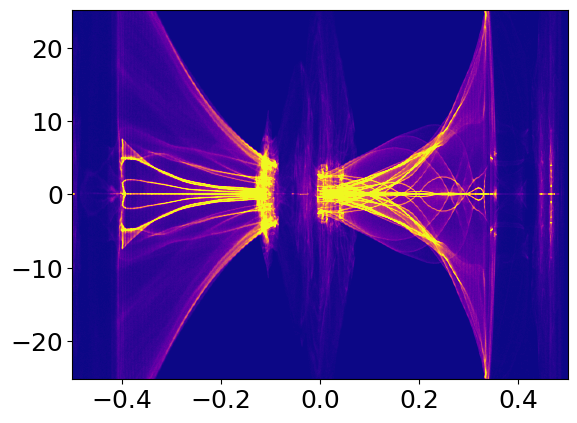

In [47]:
sideOn_re03 = pickle.load(open('/rds/general/user/le322/home/synthPy/output/fluid sim/double_mesh/colliding_mesh003_SideOn1064_refract.pkl', "rb")).H


re = Image(sideOn_re03, 0. , scale_sh_x, scale_phi)
# re.mask(10)
re.set_origin((int(1724), int(1287)))
aspect = scale_phi / scale_sh_x
fig, ax = plt.subplots()
re.plot_mm(ax, aspect = aspect, clim = (0,20),cmap = 'plasma')

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

# plt.imshow(re, clim = (0,1))

# start = 600
# stop = 1300
# nslices = 100
# xpos = np.linspace(start, stop, nslices)
# phi= []
# for x in xpos:
#     slice1 = re[:, int(x)]
#     phi_pix = np.where(slice1 != 0)[0][0]
#     phi.append(phi_pix)

# phi = np.array(phi)
# phi = (phi*scale_phi) - (re.shape[1]//2 *scale_phi)
# plt.plot(xpos, phi)

In [48]:
# start  =  refr_sh.px_to_mm([0,0])[0]                                            # starting point slicing
start = -0.4
stop   =  0.0  

nslice =  100
tick   =  ( abs(start) + stop ) / nslice

print(start, stop, tick)



spatial   =  np.linspace(start, stop, nslice)

-0.4 0.0 0.004


-0.35 -0.1 0.0024999999999999996


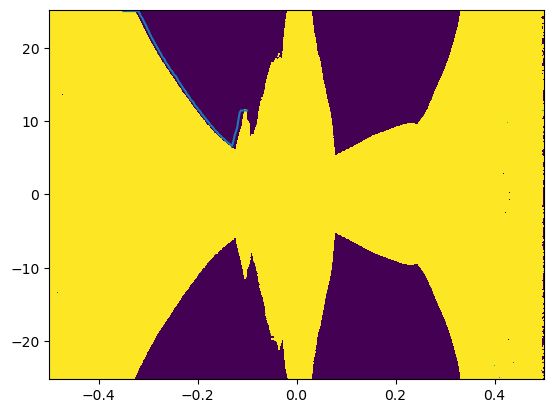

In [65]:
start = -0.35
stop   =-0.1

nslice =  100
tick   =  ( abs(start) + stop ) / nslice

print(start, stop, tick)

# re.mask(10)

fig,ax = plt.subplots()
re.plot_mm(ax, aspect = aspect, clim = (0,0.0001))

spatial   =  np.linspace(start, stop, nslice)


phi_list = []
phi = 0

for xpos in spatial:
    src             =   [xpos, -25]
    dst             =   [xpos, 25]
    r, sig       =   re.profile_mm(src, dst, 0.02)
    x_line, y_line  =   r.transpose()
    try:
        phi            =    y_line[np.where(sig !=0)[0][-1]]
    except:
        phi = np.nan
    
    phi_list.append(phi)

    
plt.plot(spatial, phi_list, markersize = 10)

0.35 0.1 0.01125


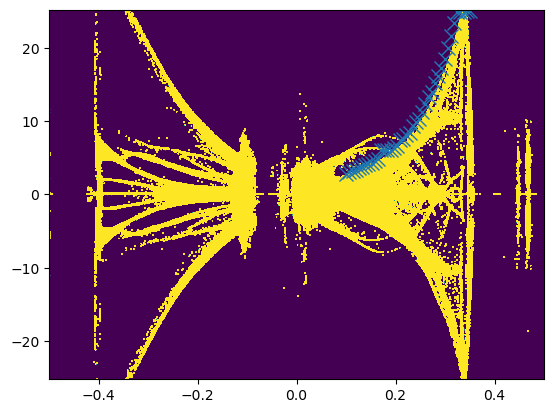

In [66]:
start = 0.35
stop   =0.1

nslice =  40
tick   =  ( abs(start) + stop ) / nslice

print(start, stop, tick)

re.mask(10)

fig,ax = plt.subplots()
re.plot_mm(ax, aspect = aspect, clim = (0,0.0001))

spatial2  =  np.linspace(start, stop, nslice)


phi_list2 = []
phi = 0

for xpos in spatial2:
    src             =   [xpos, -25]
    dst             =   [xpos, 25]
    r, sig       =   re.profile_mm(src, dst, 0.02)
    x_line, y_line  =   r.transpose()
    try:
        phi            =    y_line[np.where(sig !=0)[0][-1]]
        if len(phi_list2) > 0:
            i = -1
            while not phi < phi_list2[-1]:
                i -= 2
                phi            =    y_line[np.where(sig !=0)[0][i]]
    except:
        print('nan')
        phi = phi_list2[-1]


    
    phi_list2.append(phi)


    
plt.plot(spatial2, phi_list2, 'x', markersize = 10)

-0.4 0.4 0.008
nan


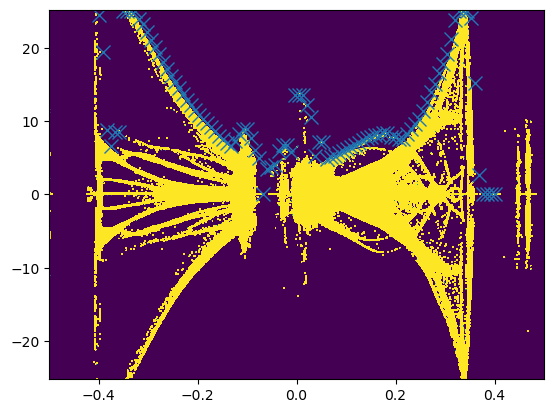

In [67]:
# start = 0.35
# stop   =0.1

start = -0.4
stop = 0.4

nslice =  100
tick   =  ( abs(start) + stop ) / nslice

print(start, stop, tick)



fig,ax = plt.subplots()
re.plot_mm(ax, aspect = aspect, clim = (0,0.0001))

spatial3  =  np.linspace(start, stop, nslice)


phi_list3 = []
phi = 0

for xpos in spatial3:
    src             =   [xpos, -25]
    dst             =   [xpos, 25]
    r, sig       =   re.profile_mm(src, dst, 0.02)
    x_line, y_line  =   r.transpose()
    try:
        phi            =    y_line[np.where(sig !=0)[0][-1]]
#         if len(phi_list2) > 0:
#             i = -1
#             while not phi < phi_list2[-1]:
#                 i -= 2
#                 phi            =    y_line[np.where(sig !=0)[0][i]]
    except:
        print('nan')
        phi = phi_list3[-1]


    
    phi_list3.append(phi)


    
plt.plot(spatial3, phi_list3, 'x', markersize = 10)

Density Gradients

In [51]:
import sys

sys.path.insert(1, '/rds/general/user/le322/home/synthPy/')

import numpy as np
from mpi4py import MPI
import pickle
from mpi4py.util import pkl5

import field_generator.gaussian1D as g1
import field_generator.gaussian2D as g2
import field_generator.gaussian3D as g3

import solver.full_solver as s
import solver.rtm_solver as rtm
import matplotlib.pyplot as plt
import gc
import vtk
from vtk.util import numpy_support as vtk_np

def pvti_readin(filename):
    '''
    Reads in data from pvti with filename, use this to read in electron number density data

    '''

    reader = vtk.vtkXMLPImageDataReader()
    reader.SetFileName(filename)
    reader.Update()

    data = reader.GetOutput()
    dim = data.GetDimensions()
    spacing = np.array(data.GetSpacing())

    v = vtk_np.vtk_to_numpy(data.GetCellData().GetArray(0))
    n_comp = data.GetCellData().GetArray(0).GetNumberOfComponents()

    vec = [int(i-1) for i in dim]

    if(n_comp > 1):
        vec.append(n_comp)

    if(n_comp > 2):
        img = v.reshape(vec,order="F")[0:dim[0]-1,0:dim[1]-1,0:dim[2]-1,:]
    else:
        img = v.reshape(vec,order="F")[0:dim[0]-1,0:dim[1]-1,0:dim[2]-1]

    dim = img.shape

    return img,dim,spacing

ne, dim, spacing = pvti_readin('/rds/general/user/le322/home/synthPy/output/fluid sim/double_mesh/double_mesh_003.pvti')


In [70]:
ne_grad = np.gradient(np.array(ne*1e6))
grad = np.sqrt(ne_grad[0]**2 + ne_grad[1]**2 + ne_grad[2]**2)/(2*3.9e27)
line_int = np.sum(grad, axis = 2)
re_sig = np.sum(line_int, axis = 1)
extent = 1e-2/2
x = np.linspace(-extent, extent, dim[0])


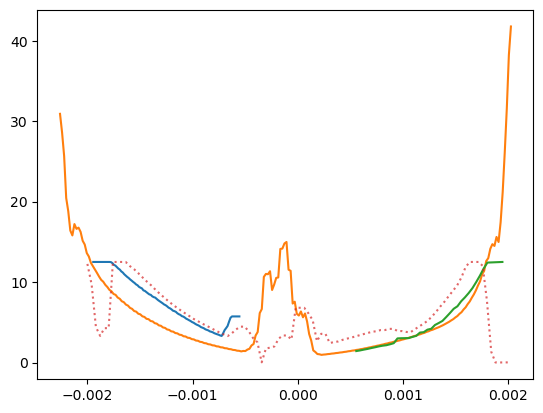

In [78]:
plt.plot(spatial/180, np.array(phi_list)/2)
plt.plot(x[140:360], re_sig[140:360])
plt.plot(spatial2/180, np.array(phi_list2)/2)
plt.plot(spatial3/200, np.array(phi_list3)/2, ':', alpha = 0.7)
plt.show()